Using TensorFlow backend.


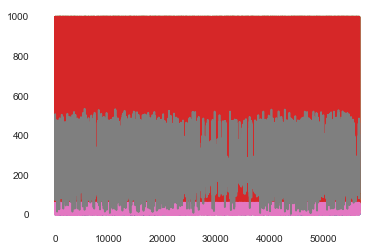

wpow  wpre   CW  CCW  wpowmax  wpowh  wpowm  maxwpre
0   1.4   128  205   75      2.9      0      4      137
1   1.2   167  999  999      2.7      0     18      171
2   1.9   179  222  149      3.2      0     25      164
3   1.7   188  279  144      3.7      0     39      175
4   1.2   166  232   74      3.2      0     40      178

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import pandas_profiling
import seaborn as sns
%matplotlib inline


#データ読み込み　Y（平均風速）は最初の列に配置する
df = pandas.read_csv("1year.csv",usecols=[6,7,8,9,10,11,12,13],  encoding="utf-8")
df = df.loc[:, ["平均風速", "平均風向", "ＣＷ極値", "ＣＣＷ極値", "最大風速", "最大風速時", "最大風速分", "最大風速風向"]]
df = df.rename(columns={'平均風向': 'wpre','ＣＷ極値': 'CW', 'ＣＣＷ極値': 'CCW', 'ＣＣＷ極値': 'CCW', '平均風速': 'wpow', '最大風速':'wpowmax', '最大風速時':'wpowh', '最大風速分': 'wpowm', '最大風速風向': 'maxwpre'})


plt.plot(df)
plt.show()
df.head()

In [2]:
#概要確認
df.describe()

wpow          wpre            CW           CCW       wpowmax  \
count  56833.000000  56833.000000  56833.000000  56833.000000  56833.000000   
mean       1.909428    271.793975    428.220558    415.996586      4.584864   
std        1.322391    110.715570    374.419632    381.920953      2.906014   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.900000    189.000000    164.000000    127.000000      2.400000   
50%        1.700000    245.000000    261.000000    230.000000      3.900000   
75%        2.600000    368.000000    999.000000    999.000000      6.000000   
max       14.400000    539.000000    999.000000    999.000000     93.700000   

              wpowh         wpowm       maxwpre  
count  56833.000000  56833.000000  56833.000000  
mean      11.507698     28.903155    258.016452  
std        6.925410     17.373605    103.197925  
min        0.000000      0.000000      2.000000  
25%        6.000000     14.000000    181.000000  
50%       12.000000     29.000000    244.000000  
75%       18.000000     44.000000    351.000000  
max       24.000000     59.000000    534.000000

In [3]:
df.columns

Index(['wpow', 'wpre', 'CW', 'CCW', 'wpowmax', 'wpowh', 'wpowm', 'maxwpre'], dtype='object')

In [4]:
#データの分布、相関などを確認
pandas_profiling.ProfileReport(df)

In [5]:
#欠損値を確認
df.isnull().sum() 

wpow       0
wpre       0
CW         0
CCW        0
wpowmax    0
wpowh      0
wpowm      0
maxwpre    0
dtype: int64

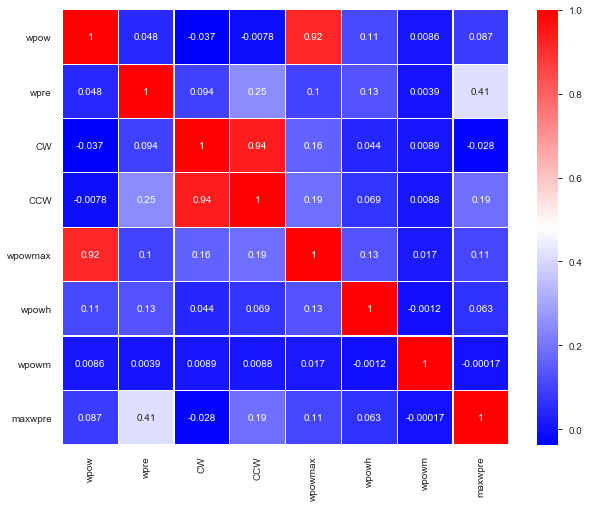

In [6]:
#ヒートマップを表示
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [7]:
#相関係数が高い2つのうち、片方を削除
df = df.drop('CCW', 1)
df = df.drop('wpowmax', 1)
df = df.drop('maxwpre', 1)
df.head()

wpow  wpre   CW  wpowh  wpowm
0   1.4   128  205      0      4
1   1.2   167  999      0     18
2   1.9   179  222      0     25
3   1.7   188  279      0     39
4   1.2   166  232      0     40

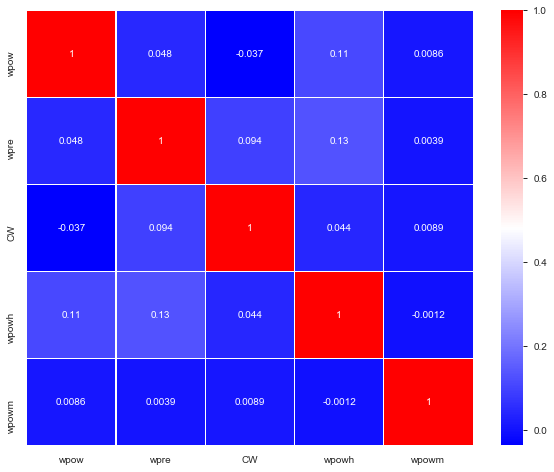

In [8]:
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [9]:
#計算に用いるためnumpyのndarrayに変換
dataset = df.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = 52513
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

52513 4320


In [10]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        dataY.append(dataset[i + look_back, 0])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

def step_decay(epoch):
    x = 0.01
    if epoch >= 50: x = 0.001
    if epoch >= 100: x = 0.0001
    return x
lr_decay = LearningRateScheduler(step_decay)


# reshape into X=t and Y=t+1
look_back = 144
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)


(52368, 5, 144)
(4175, 5, 144)
(52368,)
(4175,)


In [11]:
# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
#trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(52368, 5, 144)
(4175, 5, 144)


In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(5, 144)))	#shape：変数数、遡る時間数
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.01), metrics = ['accuracy'])
history = model.fit(trainX, trainY, batch_size=144, epochs=200, verbose=2,callbacks=[lr_decay])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 4s - loss: 0.0326 - acc: 0.0161
Epoch 2/200
 - 2s - loss: 0.0084 - acc: 0.0163
Epoch 3/200
 - 2s - loss: 0.0079 - acc: 0.0163
Epoch 4/200
 - 2s - loss: 0.0037 - acc: 0.0163
Epoch 5/200
 - 2s - loss: 0.0018 - acc: 0.0163
Epoch 6/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 7/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 8/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 9/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 10/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 11/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 12/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 13/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 14/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 15/200
 - 2s - loss: 0.0016 - acc: 0.0163
Epoch 16/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 17/200
 - 2s - loss: 0.0016 - acc: 0.0163
Epoch 18/200
 - 2s - loss: 0.0017 - acc: 0.0163
Epoch 19/200
 - 2s - loss

 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 160/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 161/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 162/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 163/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 164/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 165/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 166/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 167/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 168/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 169/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 170/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 171/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 172/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 173/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 174/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 175/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 176/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 177/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 178/200
 - 2s - loss: 0.0012 - acc: 0.0163
Epoch 179/200
 - 2s - loss: 0.0012

In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = numpy.zeros(dataset.shape[1]-1)

# invert predictions
def pad_array(val):
    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])

print(trainPredict)
print(testPredict)


[[0.11263804]
 [0.14268763]
 [0.12638728]
 ...
 [0.11063699]
 [0.10304888]
 [0.14415932]]
[[0.08528098]
 [0.09555717]
 [0.07082596]
 ...
 [0.08445018]
 [0.06868713]
 [0.1242394 ]]


In [14]:
#もとのスケールに戻す

trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))
                                 
print(trainPredict)
print(testPredict)


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

[[1.62198772 1.         0.         0.         0.        ]
 [2.05470183 1.         0.         0.         0.        ]
 [1.81997679 1.         0.         0.         0.        ]
 ...
 [1.59317264 1.         0.         0.         0.        ]
 [1.48390374 1.         0.         0.         0.        ]
 [2.07589407 1.         0.         0.         0.        ]]
[[1.22804612 1.         0.         0.         0.        ]
 [1.37602316 1.         0.         0.         0.        ]
 [1.01989384 1.         0.         0.         0.        ]
 ...
 [1.2160825  1.         0.         0.         0.        ]
 [0.98909457 1.         0.         0.         0.        ]
 [1.78904728 1.         0.         0.         0.        ]]
Train Score: 0.49 RMSE
Test Score: 0.52 RMSE


In [15]:
print(testY[:,0])
print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


[1.20000009 1.20000009 1.         ... 1.         2.         1.79999991]
[1.22804612 1.37602316 1.01989384 ... 1.2160825  0.98909457 1.78904728]


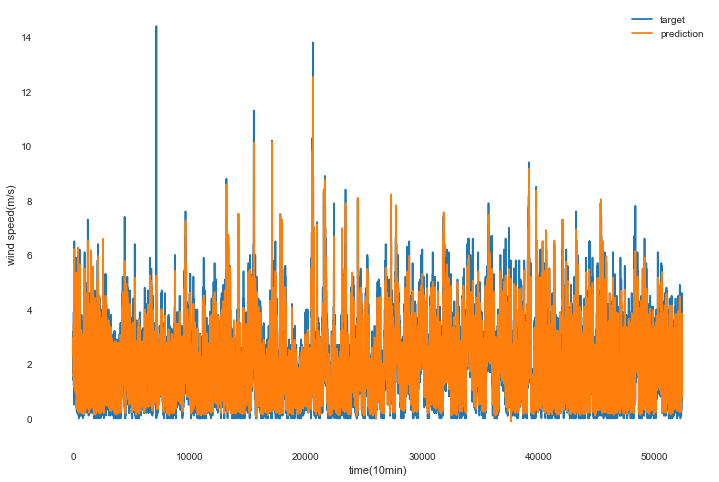

In [16]:
# plot baseline and predictions
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.plot(trainY[:,0])
plt.plot(trainPredict[:,0])

plt.xlabel("time(10min)")
plt.ylabel("wind speed(m/s)")
plt.legend(["target", "prediction"],loc='upper right')
plt.show()

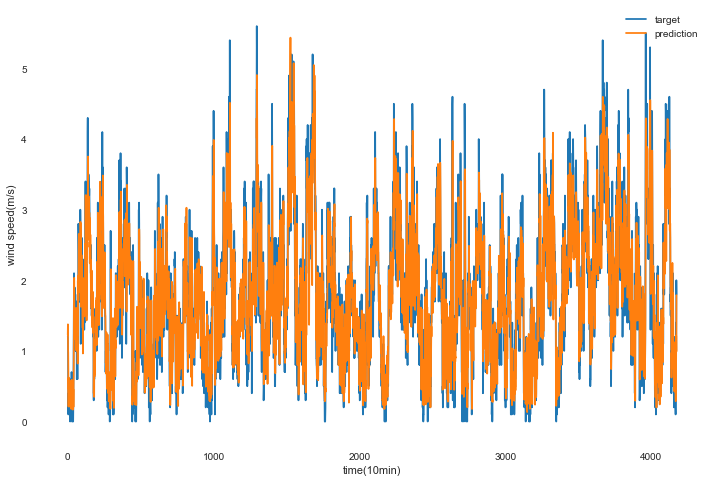

In [17]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 15
plt.plot(testY[:,0])
plt.plot(testPredict[:,0])

plt.xlabel("time(10min)")
plt.ylabel("wind speed(m/s)")
plt.legend(["target", "prediction"], loc='upper right')
plt.show()

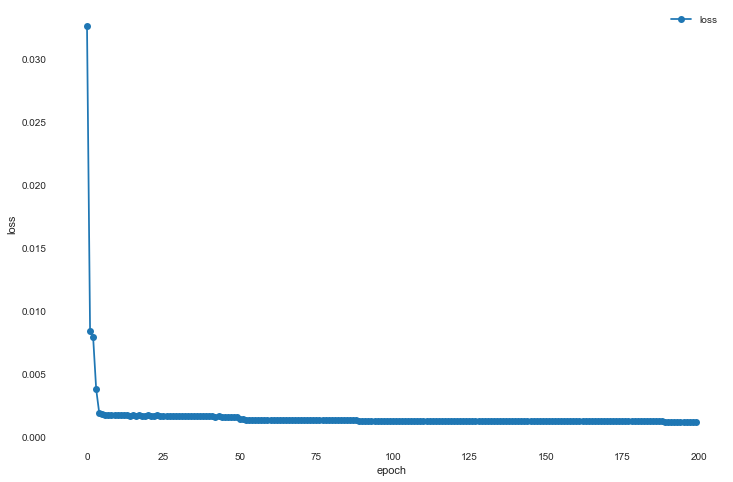

In [18]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.plot(history.history["loss"], label="loss", ls="-", marker="o")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

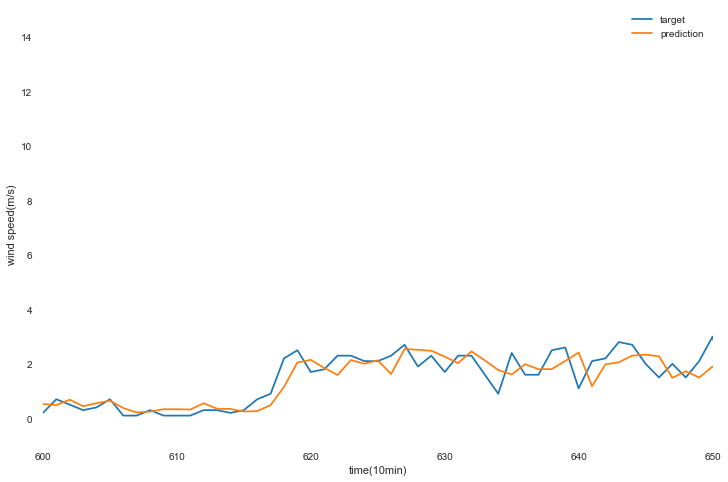

In [19]:
# plot baseline and predictions
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 15
plt.plot(trainY[:,0])
plt.plot(trainPredict[:,0])
plt.xlim([600,650])

plt.xlabel("time(10min)")
plt.ylabel("wind speed(m/s)")
plt.legend(["target", "prediction"], loc='upper right')
plt.show()

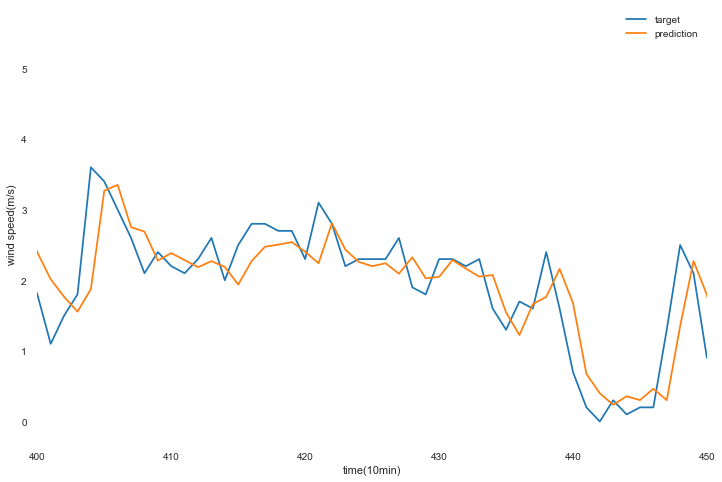

In [20]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 15
plt.plot(testY[:,0])
plt.plot(testPredict[:,0])
plt.xlim([400,450])


plt.xlabel("time(10min)")
plt.ylabel("wind speed(m/s)")
plt.legend(["target", "prediction"], loc='upper right')
plt.show()